In [12]:
%matplotlib notebook

import matplotlib.pyplot as plt
import pvlib

Carga un lugar de PVGIS (https://re.jrc.ec.europa.eu/pvg_tools/es/tools.html#TMY, casi cualquier lugar del mundo) dadas las coordenadas (la altitud la da PVGIS según las coordenadas). Feel free!

Sky diffuse models (https://pvlib-python.readthedocs.io/en/stable/api.html#transposition-models) include:
    * isotropic (default)
    * klucher
    * haydavies
    * reindl
    * king
    * perez
    
Según PVGIS,
>Las pérdidas estimadas del sistema son todas aquellas pérdidas dentro del mismo que hacen que la potencia realmente entregada a la red eléctrica sea inferior a la potencia producida por los módulos fotovoltaicos. Existen varias causas como pérdidas en el cableado, en los inversores, suciedad (en ocasiones nieve) sobre los módulos, etc. A lo largo de los años el rendimiento de los módulos también tiende a disminuir, por lo que la potencia media entregada anualmente durante la vida útil del sistema será inferior a la potencia entregada durante los primeros años.
Se asumen unas pérdidas generales, por defecto, del __14%__. Si el usuario dispone de otro dato (quizás debido al uso de un inversor con un rendimiento muy alto) este valor podría reducirse ligeramente.

In [13]:
lat, lon = 40.4, -3.7
tilt = lat - 10
diffuse_model = 'haydavies'

In [14]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

data[['poa_global', 'poa_diffuse']] = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt, surface_azimuth=180,
                         solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
                         dni=data['dni'], ghi=data['ghi'], dhi=data['dhi'],
                         dni_extra=pvlib.irradiance.get_extra_radiation(data.index), model=diffuse_model,
                         model_perez='allsitescomposite1990'
                        )[['poa_global', 'poa_diffuse']]

<IPython.core.display.Javascript object>


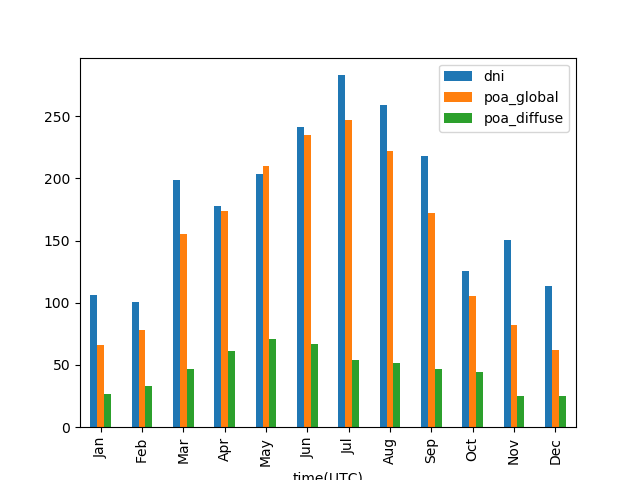

dni            2176.388950
poa_global     1806.462545
poa_diffuse     552.876500
dtype: float64


In [15]:
data_monthly = data[['dni', 'poa_global', 'poa_diffuse']].resample('M').sum() / 1000

ax = data_monthly.plot(kind='bar')
ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(data_monthly.sum())